In [1]:
# Cell 1

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import os
import pandas as pd
import glob
from scipy.optimize import curve_fit

# GLOBAL PLOTTING STYLE
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.size"]      = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["legend.fontsize"] = 12

print("SECTION 1 COMPLETE: Necessary imports and global setup done.")

# Cell 2

# PURPOSE:
#   1) Define a function "Read" that reads our snapshot files from scratch
#   2) Demonstrate reading snapshot data for MW, M31, M33
#   3) Store or display relevant info

from P1Read import Read

print("SECTION 2 COMPLETE: Defined the Read() function to parse snapshot data.")

# Cell 3

# Center-of-Mass and Orbit Computations
#
# 1) Takes in the snapshot data array (type, m, x, y, z, vx, vy, vz)
# 2) Filters on a chosen particle type (1=halo, 2=disk, 3=bulge)
# 3) Implements the iterative COM approach for position (COM_P)
# 4) Implements a method for COM velocity (COM_V)
# 
# Then we'll compute the COM for MW, M31, and M33 as a demonstration.

from P2CenterOfMass import CenterOfMass

print("SECTION 3 COMPLETE: A new 'CenterOfMass' class has been defined.")


SECTION 1 COMPLETE: Necessary imports and global setup done.
SECTION 2 COMPLETE: Defined the Read() function to parse snapshot data.
SECTION 3 COMPLETE: A new 'CenterOfMass' class has been defined.


In [2]:
# Cell 4
# uncomment only to run and save file when needed

#build COM catalogue for all snapshots

galaxy_folders = ["MW", "M31", "M33"]
ptype_list     = [1, 2, 3]          # 1 = Halo, 2 = Disk, 3 = Bulge
records        = []

# helper to squash NaN / Inf to 0.0  (avoids six identical if‑blocks)
_clean = lambda v: 0.0 if (np.isnan(v) or np.isinf(v)) else v

for gal in galaxy_folders:
    for filename in sorted(glob.glob(f"{gal}/{gal}_*.txt")):
        time_myr, total_p, data_array = Read(filename)
        snap_str = filename.split("_")[-1].replace(".txt", "")

        for ptype in ptype_list:
            com      = CenterOfMass(data_array, ptype)
            # COM position / velocity (fall back to zeros on failure)
            try:
                xcom, ycom, zcom = com.COM_P(delta=0.1)
                vxcom, vycom, vzcom = com.COM_V(xcom, ycom, zcom, rvmax=15.0)
            except Exception:
                xcom = ycom = zcom = vxcom = vycom = vzcom = 0.0

            # clean NaN / Inf once, with helper
            xcom, ycom, zcom = map(_clean, (xcom, ycom, zcom))
            vxcom, vycom, vzcom = map(_clean, (vxcom, vycom, vzcom))

            records.append(
                dict(galaxy=gal, snapshot=snap_str, time_Myr=time_myr,
                     ptype=ptype, xcom=xcom, ycom=ycom, zcom=zcom,
                     vxcom=vxcom, vycom=vycom, vzcom=vzcom)
            )

df = pd.DataFrame(records)
df.to_csv("All_COM.csv", index=False)
print(f"Saved COM data to All_COM.csv with {len(df)} rows.")


/Users/animeshgarg/Desktop/ASTR400B-Garg/ResearchAssignments/Project Final Code:Result/P2CenterOfMass.py:51: RuntimeWarning: invalid value encountered in scalar divide
  a_com = np.sum(a * m) / np.sum(m)
/Users/animeshgarg/Desktop/ASTR400B-Garg/ResearchAssignments/Project Final Code:Result/P2CenterOfMass.py:52: RuntimeWarning: invalid value encountered in scalar divide
  b_com = np.sum(b * m) / np.sum(m)
/Users/animeshgarg/Desktop/ASTR400B-Garg/ResearchAssignments/Project Final Code:Result/P2CenterOfMass.py:53: RuntimeWarning: invalid value encountered in scalar divide
  c_com = np.sum(c * m) / np.sum(m)


Saved COM data to All_COM.csv with 7218 rows.


Saved 802 rows to JacobiRadius.csv.


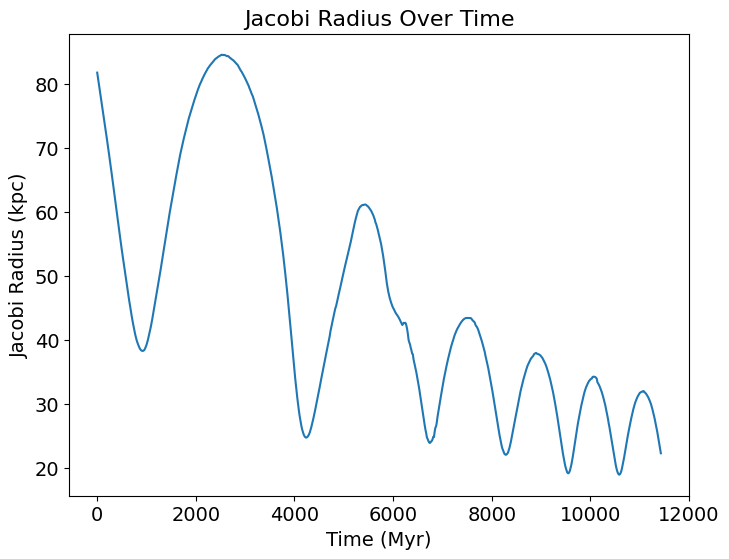

In [3]:
# Cell 5
# Define a MassProfile class
#
# PURPOSE:
# For a galaxy's snapshot data (mw_data, m31_data, or m33_data) plus that galaxy's center (xCOM,yCOM,zCOM),
# we can compute the enclosed mass at any given radius for each ptype or the total.
from P3MassProfile import MassProfile

# Cell 6
# Jacobi Functions
from P4JacobiRadius import compute_jacobi_radius
from P4JacobiRadius import jacobi_usage

# now run
jacobi_usage()

# Cell 7
df_jacobi = pd.read_csv("JacobiRadius.csv")
plt.plot(df_jacobi["time_Myr"], df_jacobi["JacobiR"], '-')
plt.xlabel("Time (Myr)")
plt.ylabel("Jacobi Radius (kpc)")
plt.title("Jacobi Radius Over Time")
plt.savefig("Jacobi Radius Over Time.png", dpi=300)
plt.show()


Initial M33 stellar mass (snapshot 000) = 9.30e+09 Msun
Mass‑loss results saved to M33_MassLoss.csv with 802 rows.


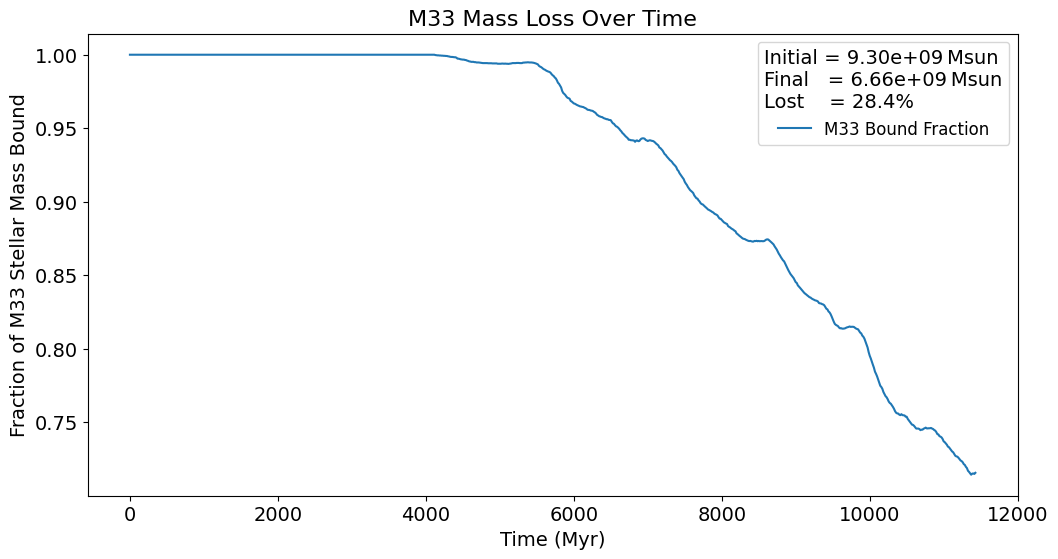

In [4]:
# Cell 8 ── M 33 stellar‑mass loss versus Jacobi radius

from P5MassLoss import dist3d, mass_loss_m33

# run the analysis
mass_loss_m33()

# Cell 9 ── plot M 33 mass‑loss history  (imports already present)

def plot_m33_mass_loss():
    df_loss = pd.read_csv("M33_MassLoss.csv")
    if df_loss.empty:
        print("No data in M33_MassLoss.csv. Exiting.")
        return

    initial_mass = df_loss.Mstar_bound.iloc[0] / df_loss.frac_bound.iloc[0]
    final_mass   = df_loss.Mstar_bound.iloc[-1]
    frac_lost    = 1.0 - df_loss.frac_bound.iloc[-1]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df_loss.time_Myr, df_loss.frac_bound, '-', label="M33 Bound Fraction")

    legend_title = (f"Initial = {initial_mass:.2e} Msun\n"
                    f"Final   = {final_mass:.2e} Msun\n"
                    f"Lost    = {frac_lost*100:.1f}%")
    ax.legend(title=legend_title)

    ax.set_xlabel("Time (Myr)")
    ax.set_ylabel("Fraction of M33 Stellar Mass Bound")
    ax.set_title("M33 Mass Loss Over Time")
    plt.savefig("M33 Mass Loss Over Time.png", dpi=300)
    plt.show()


plot_m33_mass_loss()


In [10]:
# Cell 10 

from P6DiskProfiler import DiskProfiler
profiler = DiskProfiler()
profiler.run()

from P7DiskKinematics import compute_disk_kinematics,disk_kinematics
disk_kinematics()

from P8FinalReporting import final_reporting
final_reporting()

from P9MorphologyAnalyzer import MorphologyAnalyzer
analyzer = MorphologyAnalyzer(datapath='M33/', output_file='M33_morphology_results.txt')
analyzer.analyze_snapshots(snaprange=range(0, 802, 1))

/Users/animeshgarg/Desktop/ASTR400B-Garg/ResearchAssignments/Project Final Code:Result/P6DiskProfiler.py:53: RuntimeWarning: overflow encountered in exp
  return I0 * np.exp(-b * ((r / re)**(1 / n) - 1.0))
/Users/animeshgarg/Desktop/ASTR400B-Garg/ResearchAssignments/Project Final Code:Result/P6DiskProfiler.py:53: RuntimeWarning: overflow encountered in exp
  return I0 * np.exp(-b * ((r / re)**(1 / n) - 1.0))
/Users/animeshgarg/Desktop/ASTR400B-Garg/ResearchAssignments/Project Final Code:Result/P6DiskProfiler.py:53: RuntimeWarning: overflow encountered in exp
  return I0 * np.exp(-b * ((r / re)**(1 / n) - 1.0))
/Users/animeshgarg/Desktop/ASTR400B-Garg/ResearchAssignments/Project Final Code:Result/P6DiskProfiler.py:53: RuntimeWarning: overflow encountered in exp
  return I0 * np.exp(-b * ((r / re)**(1 / n) - 1.0))
/Users/animeshgarg/Desktop/ASTR400B-Garg/ResearchAssignments/Project Final Code:Result/P6DiskProfiler.py:53: RuntimeWarning: overflow encountered in exp
  return I0 * np.exp(-b

Created M33_DiskProfileFits.csv with 802 rows.
disk_kinematics_demo finished — wrote 16040 rows.
Saved M33_DiskProfileFits.png
Wrote a small summary table to Final_Summary.csv.
All final plotting/reporting steps completed.
Done. Results saved to M33_morphology_results.txt


/var/folders/rw/vhqnc3wj2t7fqp8k4fwy4y1w0000gn/T/ipykernel_6755/3815371534.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = (pd.read_csv(RESULTS_FILE,


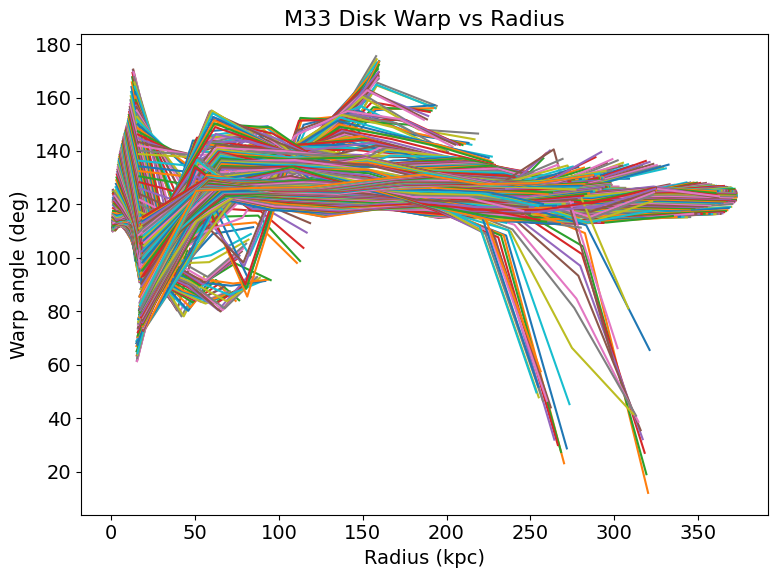

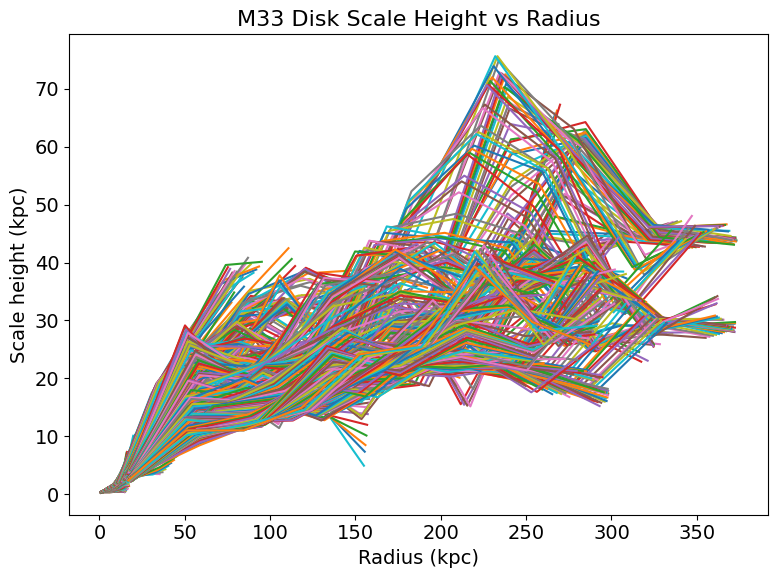

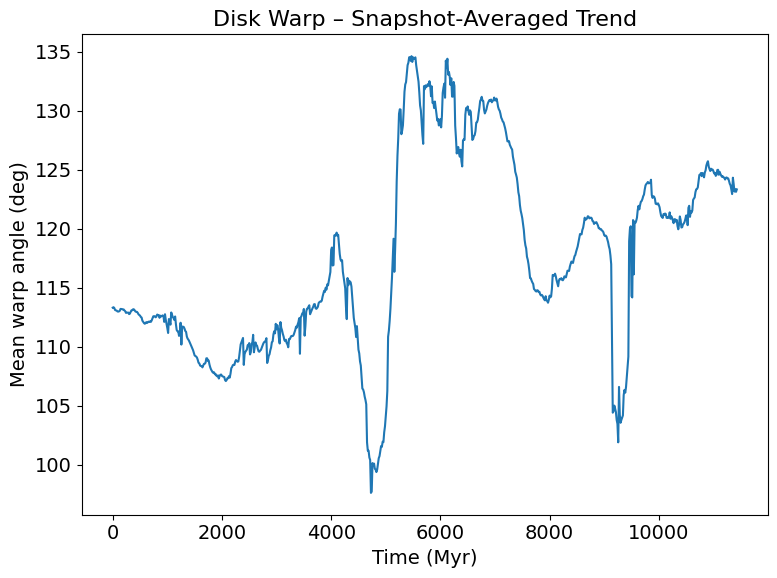

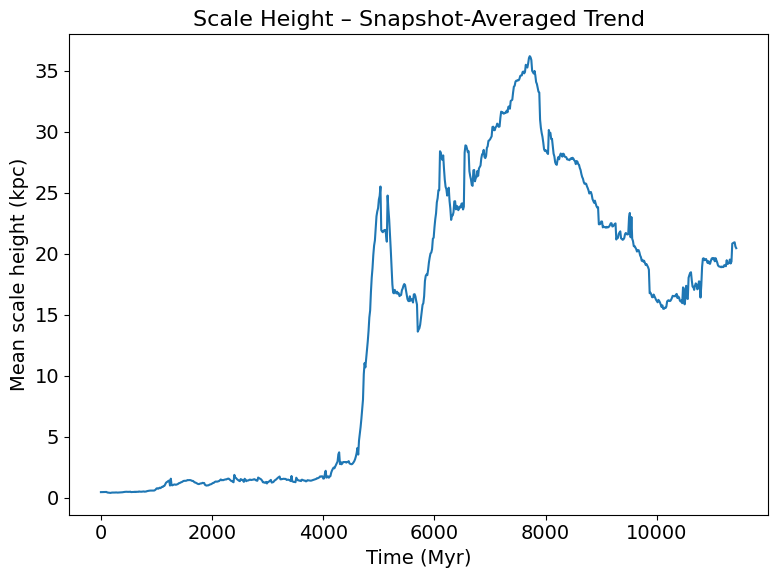

In [8]:
# Cell 11  ── morphology‑results visualisation

RESULTS_FILE = "M33_morphology_results.txt"

# 1. Load the results table once
df = (pd.read_csv(RESULTS_FILE,
                  comment="#",
                  delim_whitespace=True,
                  names=["snapshot", "time_Myr", "R_kpc",
                         "warp_deg", "scale_kpc"])
        .dropna(subset=["warp_deg", "scale_kpc"]))

unique_snaps = np.sort(df.snapshot.unique())

# 2. Warp angle vs radius for each snapshot
plt.figure()
for snap in unique_snaps:
    sub = df[df.snapshot == snap]
    plt.plot(sub.R_kpc, sub.warp_deg, label=f"snap {snap}")
plt.xlabel("Radius (kpc)")
plt.ylabel("Warp angle (deg)")
plt.title("M33 Disk Warp vs Radius")
plt.tight_layout()
plt.savefig("warp_vs_radius.png", dpi=300)
plt.show()

# 3. Scale height vs radius for each snapshot
plt.figure()
for snap in unique_snaps:
    sub = df[df.snapshot == snap]
    plt.plot(sub.R_kpc, sub.scale_kpc, label=f"snap {snap}")
plt.xlabel("Radius (kpc)")
plt.ylabel("Scale height (kpc)")
plt.title("M33 Disk Scale Height vs Radius")
plt.tight_layout()
plt.savefig("scaleheight_vs_radius.png", dpi=300)
plt.show()

# 4. Snapshot‑averaged trends (mean over the 10 radial bins)
snap_stats = (df.groupby("snapshot")
                .agg(time_Myr=("time_Myr", "first"),
                     warp_mean=("warp_deg",  "mean"),
                     scale_mean=("scale_kpc", "mean"))
                .reset_index())

# 4a. Mean warp vs time
plt.figure()
plt.plot(snap_stats.time_Myr, snap_stats.warp_mean)
plt.xlabel("Time (Myr)")
plt.ylabel("Mean warp angle (deg)")
plt.title("Disk Warp – Snapshot‑Averaged Trend")
plt.tight_layout()
plt.savefig("warp_vs_time_avg.png", dpi=300)
plt.show()

# 4b. Mean scale height vs time
plt.figure()
plt.plot(snap_stats.time_Myr, snap_stats.scale_mean)
plt.xlabel("Time (Myr)")
plt.ylabel("Mean scale height (kpc)")
plt.title("Scale Height – Snapshot‑Averaged Trend")
plt.tight_layout()
plt.savefig("scaleheight_vs_time_avg.png", dpi=300)
plt.show()


In [ ]:
import nbformat

notebook_path = 'P0MainCode.ipynb'

nb = nbformat.read(notebook_path, as_version=4)

total_code_lines = 0

for cell in nb.cells:
    if cell.cell_type == 'code':
        lines = cell.source.splitlines()
        total_code_lines += len(lines)

print(f"Total lines of code in the notebook: {total_code_lines}")
